# Run Backtest Pipeline

This notebook demonstrates running the backtest pipeline step by step.

In [1]:
import sys
sys.path.append('..')

from src.data.data_loader import DataLoader
from src.data.data_processor import DataProcessor
from src.indicators.bollinger_bands import add_bollinger_bands
from src.indicators.rsi import add_rsi
from src.indicators.atr import add_atr
from src.strategy.signal_generator import SignalGenerator
from src.strategy.risk_manager import RiskManager
from src.backtest.backtest_engine import BacktestEngine
from src.backtest.performance import PerformanceMetrics
from src.visualization.backtest import plot_backtest_results, plot_performance_metrics, plot_equity_curve, plot_trade_analysis

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, time, timedelta

os.makedirs('results', exist_ok=True)
os.makedirs('data_cache', exist_ok=True)

sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (14, 8)

## Step 1: Load Market Data

In [2]:
from src.optimization.config_loader import ConfigLoader

config_loader = ConfigLoader()
config = config_loader.get_config()

params = config_loader.get_default_parameters()
bb_window = params.get("bb_window", 20)
bb_std = params.get("bb_std", 1.8)
rsi_period = params.get("rsi_period", 13)
rsi_lower = params.get("rsi_lower", 30)
rsi_upper = params.get("rsi_upper", 70)
atr_period = params.get("atr_period", 14)
take_profit_mult = params.get("take_profit_mult", 4.0)
stop_loss_mult = params.get("stop_loss_mult", 1.0)
timeframe = params.get("default_timeframe", "15min")

print(f"\nStrategy Parameters:")
print(f"Timeframe: {timeframe}")
print(f"Bollinger Bands: Window={bb_window}, StdDev={bb_std}")
print(f"RSI: Period={rsi_period}, Oversold={rsi_lower}, Overbought={rsi_upper}")
print(f"ATR: Period={atr_period}")
print(f"Take Profit: {take_profit_mult}x ATR")
print(f"Stop Loss: {stop_loss_mult}x ATR")

2025-04-22 21:35:14,307 - config_loader - INFO - Loaded strategy configuration from ../config/strategy_config.json



Strategy Parameters:
Timeframe: 15min
Bollinger Bands: Window=20, StdDev=1.8
RSI: Period=13, Oversold=30, Overbought=70
ATR: Period=14
Take Profit: 4.0x ATR
Stop Loss: 1.0x ATR


## Step 2: Process Data and Add Indicators

In [3]:
start_date = '2024-01-01'
end_date = '2024-06-01'

loader = DataLoader(cache_dir="data_cache")
processor = DataProcessor(cache_dir="data_cache/ohlcv")

print(f"Loading market data from {start_date} to {end_date}...")
data = loader.get_active_contract_data(start_date, end_date)
print(f"Loaded {len(data)} tick data points")

print(f"\nResampling to {timeframe} candles...")
ohlcv_data = processor.resample_to_ohlcv(data, timeframe=timeframe)
print(f"Created {len(ohlcv_data)} OHLCV candles")

print("\nSample OHLCV data:")
display(ohlcv_data.head())

Loading market data from 2024-01-01 to 2024-06-01...
Loaded 344027 tick data points

Resampling to 15min candles...
Created 1892 OHLCV candles

Sample OHLCV data:


,open,high,low,close,volume,tickersymbol
datetime,,,,,,
2024-01-02 09:00:00,1138.50,1141.50,1138.50,1141.40,1506679.0,VN30F2401
2024-01-02 09:15:00,1141.30,1141.80,1139.60,1139.70,3224666.0,VN30F2401
2024-01-02 09:30:00,1139.90,1140.00,1139.30,1139.80,3541710.0,VN30F2401
2024-01-02 09:45:00,1139.90,1140.80,1139.70,1140.80,4127474.0,VN30F2401
2024-01-02 10:00:00,1140.70,1140.90,1139.60,1139.90,4407057.0,VN30F2401


## Step 3: Generate Trading Signals

In [4]:
from src.pipeline import TradingPipeline
pipeline = TradingPipeline(config)

print("Adding technical indicators...")
prepared_data = pipeline.prepare_data(data, timeframe=timeframe)

print("\nData with indicators:")
display(prepared_data.tail())

2025-04-22 21:36:08,338 - trading_pipeline - INFO - Resampling data to 15min timeframe


Adding technical indicators...


2025-04-22 21:36:08,563 - trading_pipeline - INFO - Adding indicators to data



Data with indicators:


,datetime,open,high,low,close,volume,tickersymbol,upper_band,middle_band,lower_band,rsi,atr
1887,2024-05-31 13:45:00,1271.7,1272.4,1270.3,1271.9,26405064.0,VN30F2406,1275.655872,1270.755,1265.854128,53.571429,2.142857
1888,2024-05-31 14:00:00,1271.7,1273.5,1266.7,1268.1,35652217.0,VN30F2406,1274.786940,1271.020,1267.253060,42.553191,2.435714
1889,2024-05-31 14:15:00,1268.0,1271.5,1267.0,1268.3,34015036.0,VN30F2406,1274.120570,1271.200,1268.279430,43.971631,2.650000
1890,2024-05-31 14:30:00,1268.2,1270.2,1268.0,1270.0,195379.0,VN30F2406,1274.122262,1271.195,1268.267738,39.694656,2.728571
1891,2024-05-31 14:45:00,1270.0,1270.0,1270.0,1270.0,195427.0,VN30F2406,1274.122262,1271.195,1268.267738,29.464286,2.485714


Plotting candlestick chart for the last 200 candles...


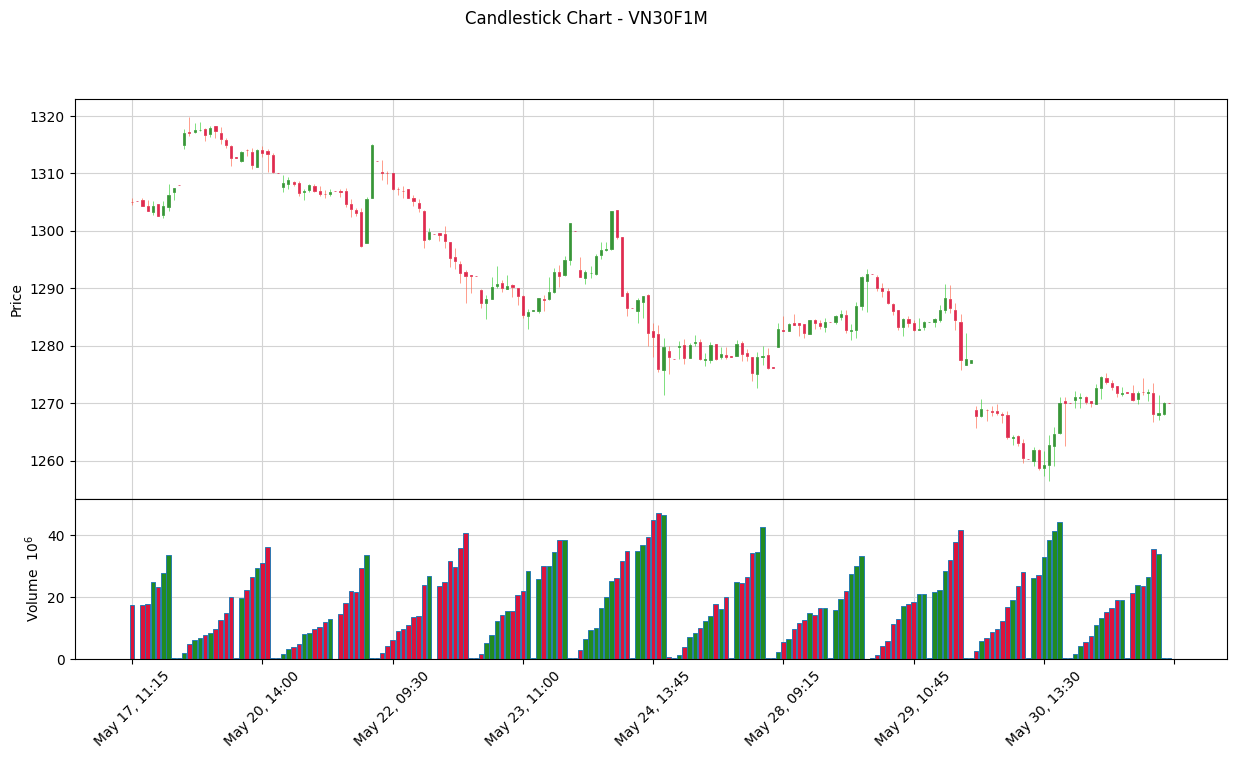

In [5]:
from src.visualization.backtest import plot_candles

window_size = 200
if len(prepared_data) > window_size:
    plot_window = prepared_data.iloc[-window_size:]
else:
    plot_window = prepared_data

print(f"Plotting candlestick chart for the last {len(plot_window)} candles...")
fig = plot_candles(
    plot_window, 
    ticker="VN30F1M",
    volume=True,
    save_path='results/candlestick_chart.png'
)
plt.show()


## Step 4: Run Backtest

In [6]:
print("Generating trading signals...")
signal_gen = SignalGenerator(rsi_lower=rsi_lower, rsi_upper=rsi_upper)
signals_df = signal_gen.generate_signals(prepared_data)

buy_signals = signals_df['buy_signal'].sum()
sell_signals = signals_df['sell_signal'].sum()
print(f"Generated {buy_signals} buy signals and {sell_signals} sell signals")

buy_examples = signals_df[signals_df['buy_signal'] == 1].head(3)
sell_examples = signals_df[signals_df['sell_signal'] == 1].head(3)

print("\nSample buy signals:")
display(buy_examples[['datetime', 'close', 'rsi', 'lower_band', 'upper_band']])

print("\nSample sell signals:")
display(sell_examples[['datetime', 'close', 'rsi', 'lower_band', 'upper_band']])

Generating trading signals...
Generated 21 buy signals and 41 sell signals

Sample buy signals:


,datetime,close,rsi,lower_band,upper_band
155,2024-01-12 09:45:00,1155.3,24.832215,1155.150263,1179.359737
191,2024-01-16 09:15:00,1161.5,26.984127,1161.087999,1175.372001
193,2024-01-16 09:45:00,1159.6,25.118483,1158.713461,1175.276539



Sample sell signals:


,datetime,close,rsi,lower_band,upper_band
49,2024-01-04 13:00:00,1159.8,74.583333,1130.663546,1163.856454
51,2024-01-04 13:30:00,1166.8,84.406780,1133.056302,1168.113698
78,2024-01-08 09:30:00,1169.7,75.954198,1152.171192,1169.998808


## Step 5: Analyze Performance

In [7]:
risk_manager = RiskManager()
backtest_engine = BacktestEngine(initial_balance=100000)

print("Running backtest...")
backtest_results = backtest_engine.run_backtest(signals_df, risk_manager)

if 'trades' in backtest_results and not backtest_results['trades'].empty:
    n_trades = len(backtest_results['trades'])
    final_balance = backtest_results['final_balance']
    print(f"Backtest completed with {n_trades} trades")
    print(f"Initial balance: $100,000")
    print(f"Final balance: ${final_balance:.2f}")
    print(f"Net P&L: ${final_balance - 100000:.2f}")
else:
    print("No trades were executed in the backtest period")

Running backtest...
Backtest completed with 55 trades
Initial balance: $100,000
Final balance: $94050.43
Net P&L: $-5949.57


## Step 6: Visualize Results

Plotting backtest results with signals...


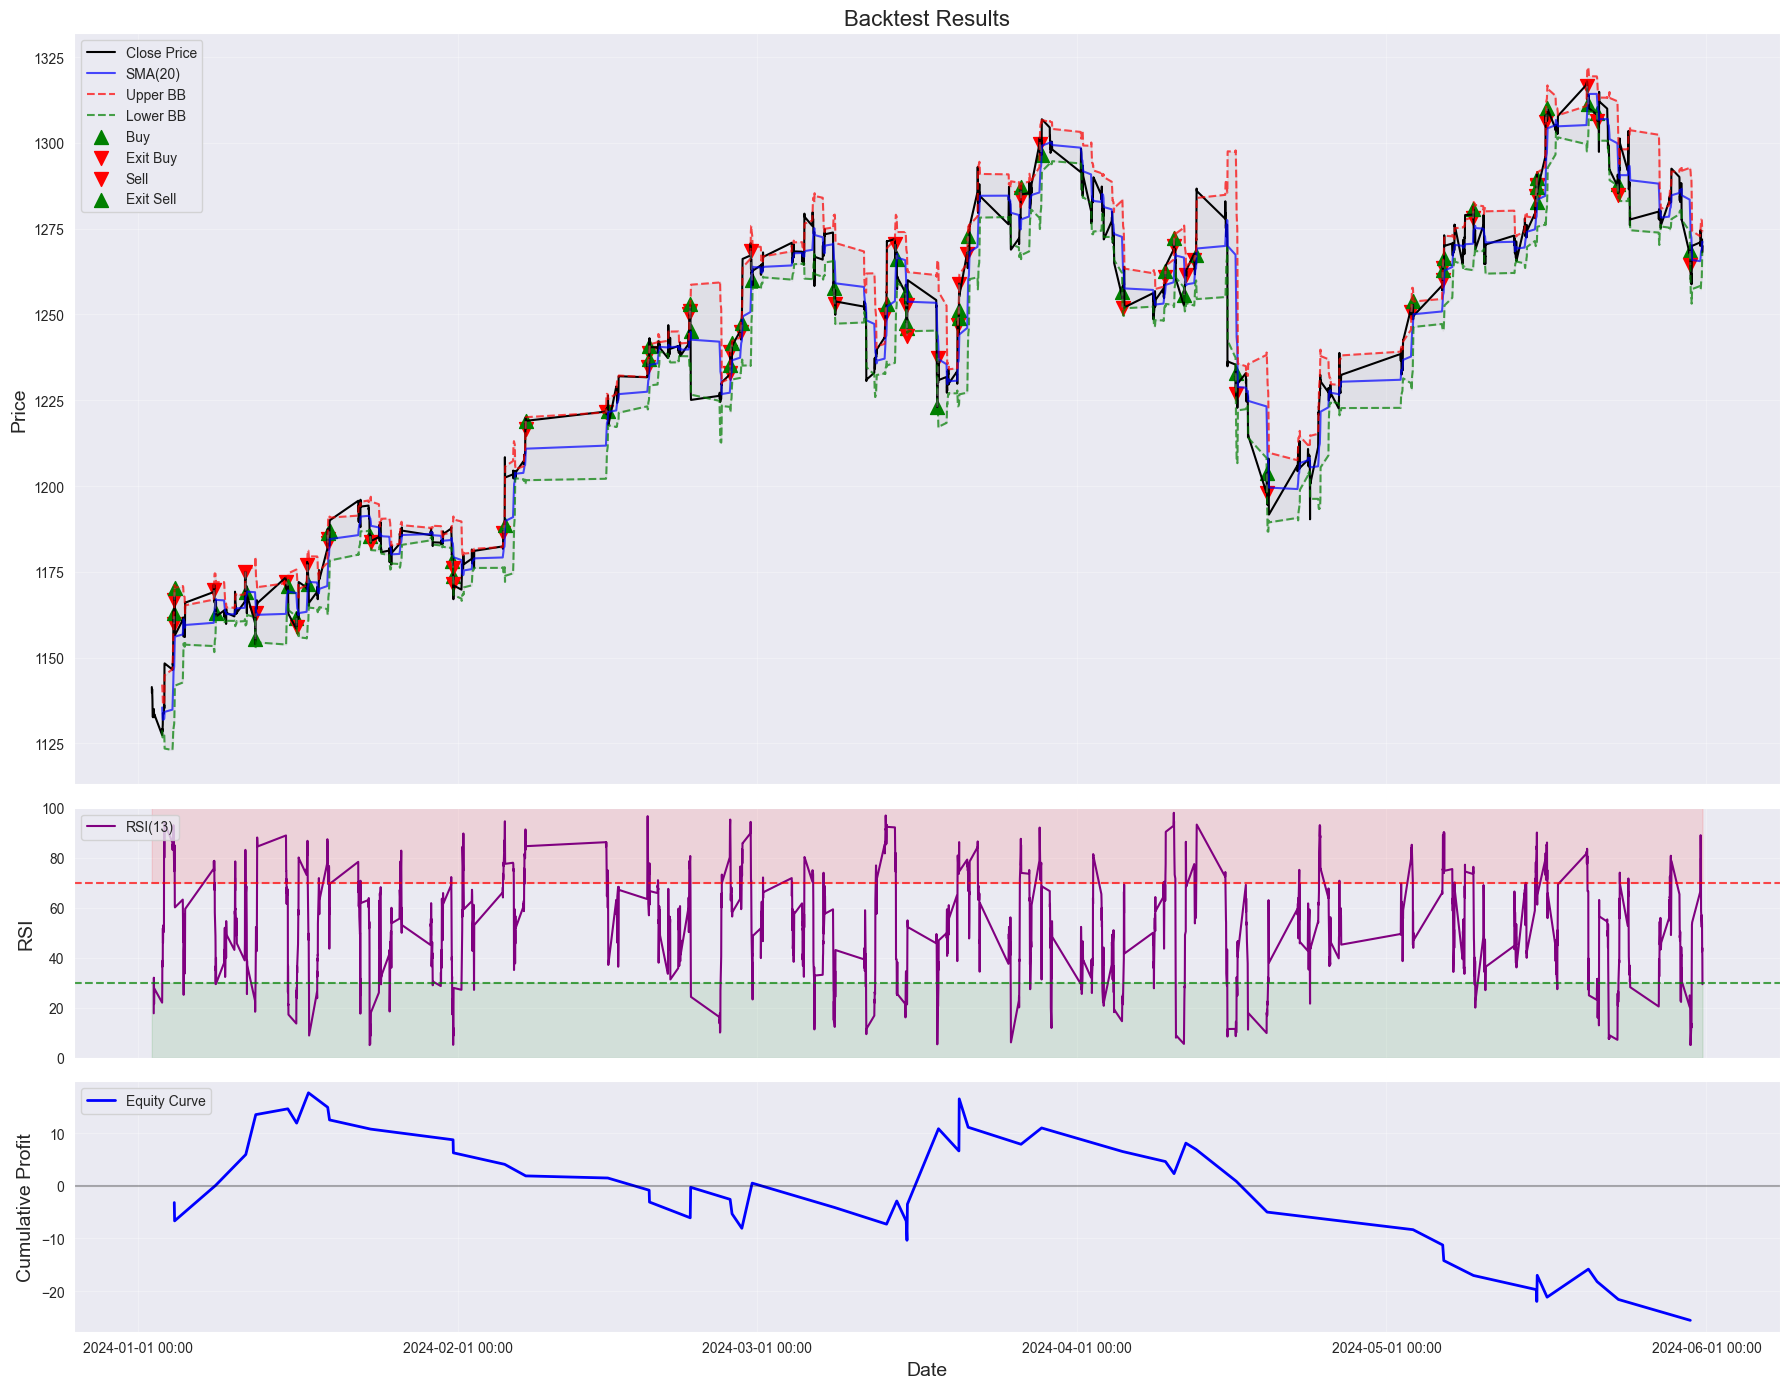

In [8]:
print("Plotting backtest results with signals...")
fig = plot_backtest_results(
    signals_df,
    trades_df=backtest_results['trades'] if 'trades' in backtest_results and not backtest_results['trades'].empty else None,
    indicators=True,
    figsize=(18, 14),
    save_path='results/backtest_chart.png'
)
plt.show()

Performance Metrics:
Win Rate: 0.2727
Profit Factor: 0.6829
Sharpe Ratio: -2.2303
Maximum Drawdown: -0.0835
Average Trade Return: -108.1739
Total Return: -0.0595
Total Trades: 55.0000
Average Win: 854.0736
Average Loss: -469.0168
Expectancy: -108.1739


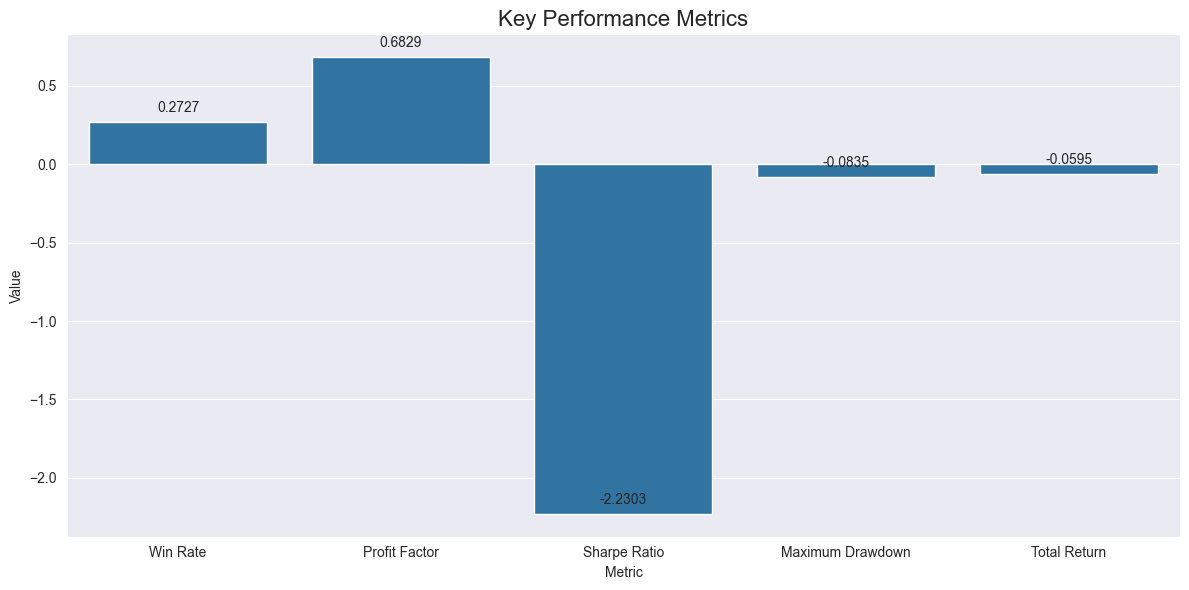

In [9]:

if 'trades' in backtest_results and not backtest_results['trades'].empty:
    performance = PerformanceMetrics(
        backtest_results['trades'], 
        backtest_results['portfolio_history']
    )
    
    metrics = performance.generate_report()
    
    print("Performance Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}" if isinstance(value, (float, int)) else f"{key}: {value}")
    
    fig = plot_performance_metrics(metrics)
    plt.show()
else:
    print("No performance metrics available - no trades were executed")

## Step 7: Save Results

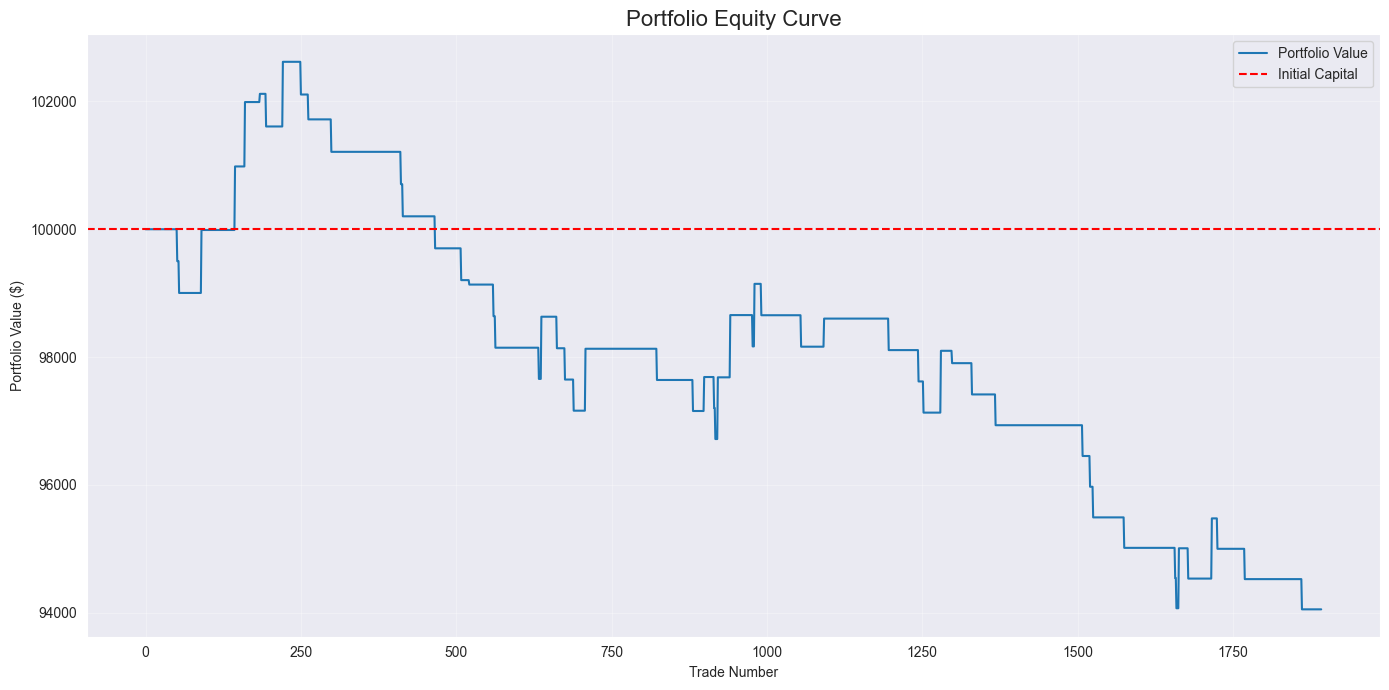

In [10]:


if 'portfolio_history' in backtest_results and len(backtest_results['portfolio_history']) > 1:
    fig = plot_equity_curve(backtest_results['portfolio_history'], save_path='results/equity_curve.png')
    plt.show()
else:
    print("No equity curve available - insufficient data")

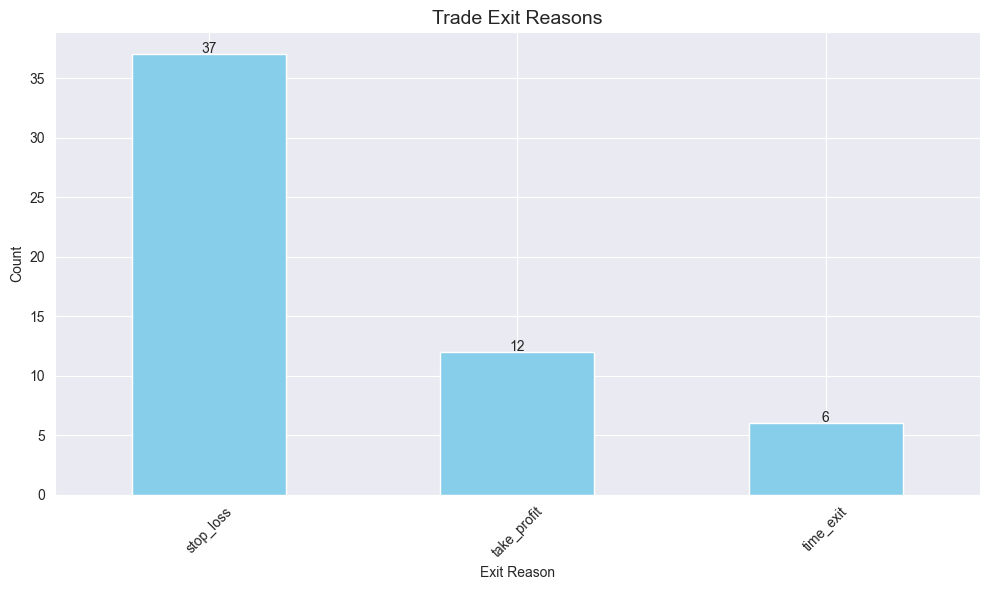

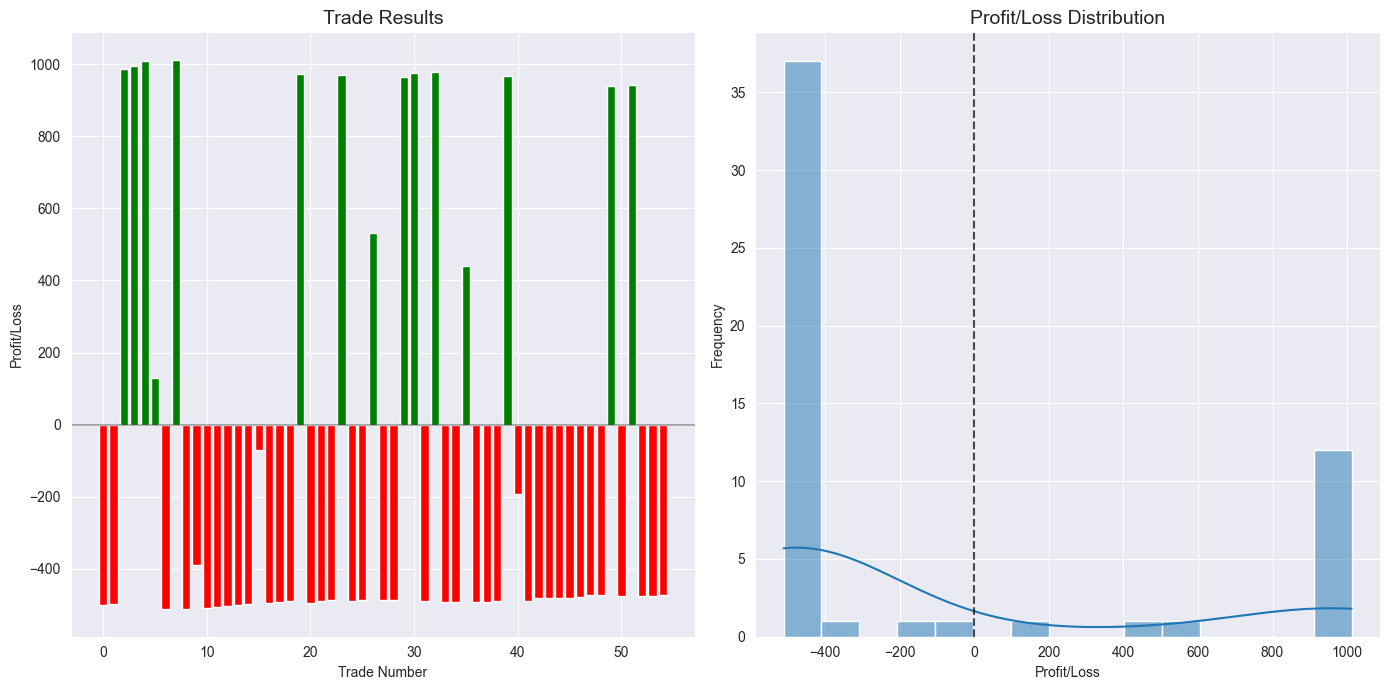

<Figure size 1400x800 with 0 Axes>


Profit by Exit Reason:


,mean,sum,count
exit_reason,,,
stop_loss,-489.416727,-18108.418900,37
take_profit,975.908829,11710.905943,12
time_exit,74.657850,447.947100,6


In [11]:


if 'trades' in backtest_results and not backtest_results['trades'].empty:
    trades_df = backtest_results['trades']
    
    fig_trades, fig_exit, profit_by_exit = plot_trade_analysis(trades_df)
    
    plt.figure(fig_trades.number)
    plt.show()
    
    if fig_exit:
        plt.figure(fig_exit.number)
        plt.show()
    
    if profit_by_exit is not None:
        print("\nProfit by Exit Reason:")
        display(profit_by_exit)
else:
    print("No trade distribution available - no trades were executed")

In [12]:
if 'trades' in backtest_results and not backtest_results['trades'].empty:
    trades_df = backtest_results['trades']
    trades_df.to_csv('results/trades.csv', index=False)
    print(f"Saved {len(trades_df)} trades to results/trades.csv")
    
    if 'metrics' in locals():
        metrics_dict = {k: float(v) if isinstance(v, (int, float, np.number)) else v for k, v in metrics.items()}
        
        result_data = {
            "parameters": params,
            "test_period": {
                "start_date": start_date,
                "end_date": end_date
            },
            "metrics": metrics_dict,
            "summary": {
                "initial_balance": 100000,
                "final_balance": float(backtest_results['final_balance']),
                "total_trades": len(trades_df),
                "buy_signals": int(buy_signals),
                "sell_signals": int(sell_signals),
                "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            }
        }
        
        with open('results/backtest_results.json', 'w') as f:
            json.dump(result_data, f, indent=4)
        
        print("Saved performance metrics to results/backtest_results.json")
else:
    print("No results saved - no trades were executed")

Saved 55 trades to results/trades.csv
Saved performance metrics to results/backtest_results.json
